In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Load dataset
# Gantilah 'dataset.csv' dengan nama file dataset Anda
# df = pd.read_csv('/content/normalisasi28-11.csv')
df = pd.read_csv('/content/smote.csv')





In [ ]:
df

,age_of_the_patient,gender_of_the_patient,total_bilirubin,direct_bilirubin,alkphos_alkaline_phosphotase,sgpt_alamine_aminotransferase,sgot_aspartate_aminotransferase,total_protiens,alb_albumin,a_g_ratio_albumin_and_globulin_ratio,result
0,0.709302,0.0,0.004021,0.000000,0.060576,0.003015,0.001626,0.594203,0.521739,0.240,0
1,0.674419,1.0,0.140751,0.275510,0.310699,0.027136,0.018296,0.695652,0.500000,0.176,0
2,0.674419,1.0,0.092493,0.204082,0.208598,0.025126,0.011791,0.623188,0.521739,0.236,0
3,0.627907,1.0,0.008043,0.015306,0.058134,0.002010,0.002033,0.594203,0.543478,0.280,0
4,0.790698,1.0,0.046917,0.096939,0.064485,0.008543,0.009961,0.666667,0.326087,0.040,0
...,...,...,...,...,...,...,...,...,...,...,...
38851,0.713972,1.0,0.002681,0.000000,0.101124,0.006533,0.006505,0.347826,0.239130,0.080,1
38852,0.294062,0.0,0.002681,0.005102,0.067904,0.001005,0.000610,0.492754,0.456522,0.240,1
38853,0.337209,1.0,0.008043,0.010204,0.064485,0.006030,0.003659,0.449275,0.369565,0.200,1
38854,0.324265,1.0,0.003870,0.005102,0.052097,0.009643,0.003023,0.623188,0.565217,0.280,1


Total jumlah setiap nilai di kolom 'Result':
result
0    19428
1    19428
Name: count, dtype: int64


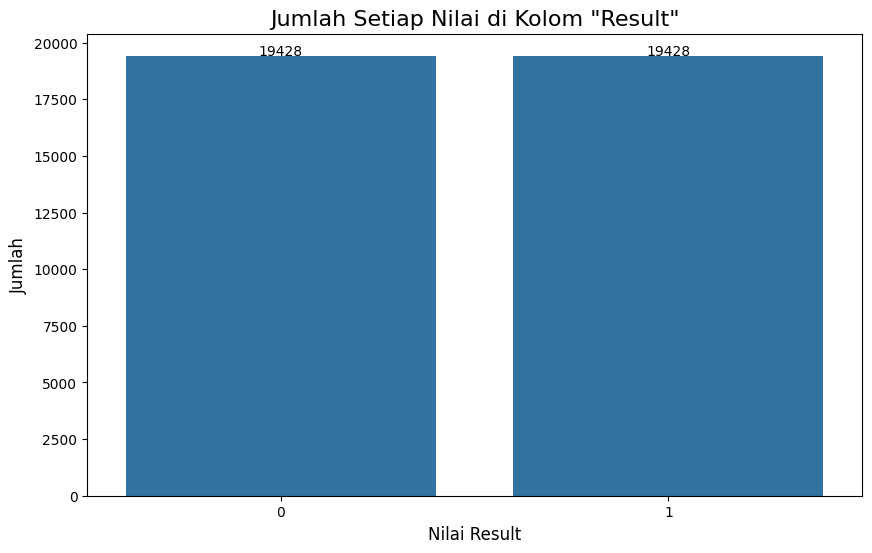

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
if 'result' in df.columns:
    result_counts = df['result'].value_counts()

    print("Total jumlah setiap nilai di kolom 'Result':")
    print(result_counts)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=result_counts.index, y=result_counts.values)

    plt.title('Jumlah Setiap Nilai di Kolom "Result"', fontsize=16)
    plt.xlabel('Nilai Result', fontsize=12)
    plt.ylabel('Jumlah', fontsize=12)

    for i, count in enumerate(result_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', fontsize=10)

    plt.show()
else:
    print("Kolom 'Result' tidak ditemukan dalam dataset.")


In [ ]:
from math import gamma
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter

# Data Preparation
X = df.drop(columns=['result'])
y = df['result']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter untuk binary classification
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.2,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Parameter grid untuk hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0.001, 0.0001, 0.01],
}

# Grid Search
print("Memulai Grid Search...")
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(**params),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Waktu pelatihan Grid Search
training_duration = end_time - start_time
print(f'Waktu yang dibutuhkan untuk Grid Search: {training_duration:.2f} detik')

# Menampilkan hasil terbaik
print("\nHasil terbaik dari Grid Search:")
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score (ROC AUC): {grid_search.best_score_:.4f}')

# Ambil model terbaik
best_model = grid_search.best_estimator_

# Konversi data ke DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Siapkan watchlist
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Callback untuk evaluasi
class LossRecorder(xgb.callback.TrainingCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.iteration_counts = []

    def after_iteration(self, model, epoch, evals_log):
        if evals_log:
            train_metrics = evals_log.get('train', {}).get('logloss', [])
            eval_metrics = evals_log.get('eval', {}).get('logloss', [])

            if train_metrics and eval_metrics:
                self.train_losses.append(train_metrics[-1])
                self.val_losses.append(eval_metrics[-1])

                # Calculate accuracies
                train_preds = model.predict(dtrain) > 0.5
                val_preds = model.predict(dtest) > 0.5
                self.train_accuracies.append(accuracy_score(y_train, train_preds))
                self.val_accuracies.append(accuracy_score(y_test, val_preds))

                self.iteration_counts.append(epoch)
        return False

# Inisialisasi callback
loss_recorder = LossRecorder()

print("\nMemulai training model final dengan parameter terbaik...")
# Training dengan callback XGBoost
model = xgb.train(
    params=best_model.get_params(),
    dtrain=dtrain,
    num_boost_round=best_model.n_estimators,
    evals=watchlist,
    verbose_eval=10,
    early_stopping_rounds=50,
    callbacks=[loss_recorder]
)



Memulai Grid Search...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Waktu yang dibutuhkan untuk Grid Search: 1186.84 detik

Hasil terbaik dari Grid Search:
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.0001, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.6}
Best cross-validation score (ROC AUC): 0.9998

Memulai training model final dengan parameter terbaik...
[0]	train-logloss:0.59055	eval-logloss:0.59001
[10]	train-logloss:0.29000	eval-logloss:0.28786


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:21:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	train-logloss:0.18010	eval-logloss:0.17952
[30]	train-logloss:0.09558	eval-logloss:0.09611
[40]	train-logloss:0.05382	eval-logloss:0.05481
[50]	train-logloss:0.03617	eval-logloss:0.03719
[60]	train-logloss:0.02277	eval-logloss:0.02362
[70]	train-logloss:0.01443	eval-logloss:0.01534
[80]	train-logloss:0.01061	eval-logloss:0.01130
[90]	train-logloss:0.00821	eval-logloss:0.00889
[100]	train-logloss:0.00665	eval-logloss:0.00740
[110]	train-logloss:0.00527	eval-logloss:0.00593
[120]	train-logloss:0.00459	eval-logloss:0.00529
[130]	train-logloss:0.00395	eval-logloss:0.00469
[140]	train-logloss:0.00340	eval-logloss:0.00412
[150]	train-logloss:0.00301	eval-logloss:0.00376
[160]	train-logloss:0.00274	eval-logloss:0.00346
[170]	train-logloss:0.00241	eval-logloss:0.00314
[180]	train-logloss:0.00220	eval-logloss:0.00289
[190]	train-logloss:0.00204	eval-logloss:0.00276
[199]	train-logloss:0.00190	eval-logloss:0.00260



Memulai visualisasi hasil training...


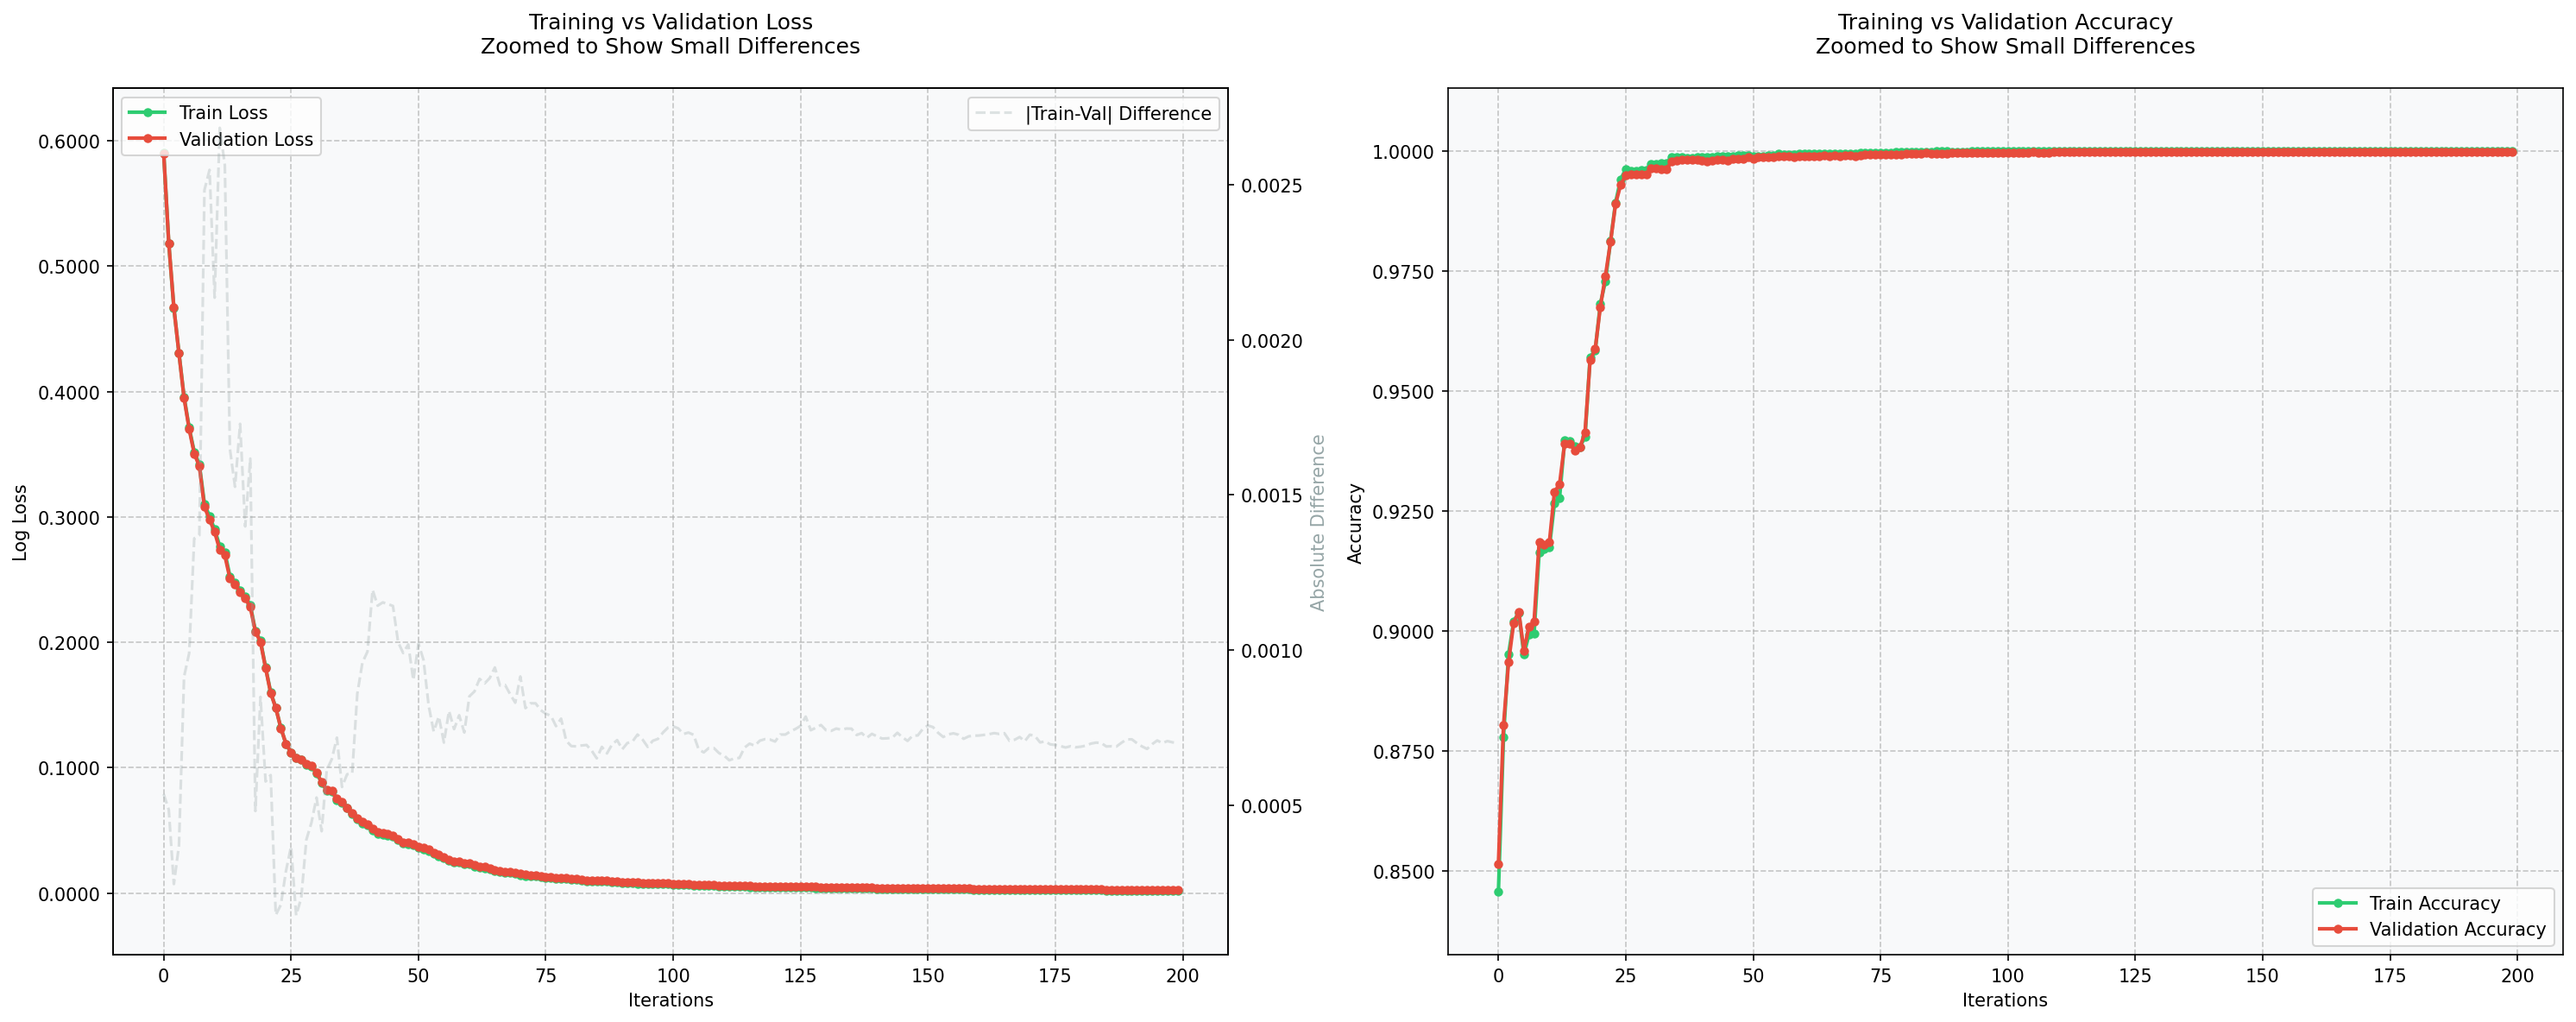

In [ ]:
# [Semua import dan kode sebelumnya tetap sama sampai bagian visualisasi]

print("\nMemulai visualisasi hasil training...")
# Set basic style
plt.style.use('default')  # Menggunakan default style matplotlib

# Atur warna yang menarik
colors = ['#2ecc71', '#e74c3c', '#95a5a6']

# Create figure with adjusted size and DPI
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=150, facecolor='white')

# Plot 1: Loss curves with enhanced visibility
train_losses = np.array(loss_recorder.train_losses)
val_losses = np.array(loss_recorder.val_losses)

# Calculate the mean and standard deviation for dynamic y-axis limits
mean_loss = np.mean([train_losses, val_losses])
std_loss = np.std([train_losses, val_losses])

# Set y-axis limits slightly above and below the actual values
y_min = min(np.min(train_losses), np.min(val_losses)) - std_loss * 0.5
y_max = max(np.max(train_losses), np.max(val_losses)) + std_loss * 0.5

# Plot training loss
ax1.plot(loss_recorder.iteration_counts, train_losses,
         label='Train Loss', linewidth=2, marker='o', markersize=4,
         color=colors[0])
ax1.plot(loss_recorder.iteration_counts, val_losses,
         label='Validation Loss', linewidth=2, marker='o', markersize=4,
         color=colors[1])

# Enhance loss plot
ax1.set_ylim(y_min, y_max)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_title('Training vs Validation Loss\nZoomed to Show Small Differences',
              fontsize=12, pad=20)
ax1.set_xlabel('Iterations', fontsize=10)
ax1.set_ylabel('Log Loss', fontsize=10)
ax1.set_facecolor('#f8f9fa')

# Add loss difference plot
loss_diff = np.absolute(train_losses - val_losses)
ax1_twin = ax1.twinx()
ax1_twin.plot(loss_recorder.iteration_counts, loss_diff,
              label='|Train-Val| Difference',
              color=colors[2], alpha=0.3, linestyle='--')
ax1_twin.set_ylabel('Absolute Difference', color=colors[2])

# Plot 2: Accuracy curves
train_accuracies = np.array(loss_recorder.train_accuracies)
val_accuracies = np.array(loss_recorder.val_accuracies)

ax2.plot(loss_recorder.iteration_counts, train_accuracies,
         label='Train Accuracy', linewidth=2, marker='o', markersize=4,
         color=colors[0])
ax2.plot(loss_recorder.iteration_counts, val_accuracies,
         label='Validation Accuracy', linewidth=2, marker='o', markersize=4,
         color=colors[1])

# Enhance accuracy plot
mean_acc = np.mean([train_accuracies, val_accuracies])
std_acc = np.std([train_accuracies, val_accuracies])
acc_y_min = min(np.min(train_accuracies), np.min(val_accuracies)) - std_acc * 0.5
acc_y_max = max(np.max(train_accuracies), np.max(val_accuracies)) + std_acc * 0.5
ax2.set_ylim(acc_y_min, acc_y_max)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_title('Training vs Validation Accuracy\nZoomed to Show Small Differences',
              fontsize=12, pad=20)
ax2.set_xlabel('Iterations', fontsize=10)
ax2.set_ylabel('Accuracy', fontsize=10)
ax2.set_facecolor('#f8f9fa')

# Add legends with better positioning
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True)
ax1_twin.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=True)
ax2.legend(loc='lower right', bbox_to_anchor=(1, 0), frameon=True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# [Semua kode print metrics tetap sama seperti sebelumnya]

In [ ]:
# Print final metrics
print("\nMetrik Final:")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")
print(f"Final Train Accuracy: {train_accuracies[-1]:.6f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.6f}")

# Print statistics about the differences
print("\nStatistik Perbedaan Loss:")
print(f"Maximum absolute difference between train and val loss: {np.max(loss_diff):.6f}")
print(f"Mean absolute difference between train and val loss: {np.mean(loss_diff):.6f}")
print(f"Standard deviation of differences: {np.std(loss_diff):.6f}")


Metrik Final:
Final Train Loss: 0.001904
Final Validation Loss: 0.002605
Final Train Accuracy: 0.999903
Final Validation Accuracy: 0.999743

Statistik Perbedaan Loss:
Maximum absolute difference between train and val loss: 0.002684
Mean absolute difference between train and val loss: 0.000794
Standard deviation of differences: 0.000345



=== Metrik Evaluasi Model (Training Set) ===
Accuracy: 0.9999
Precision: 1.0000
Recall: 0.9998
F1 Score: 0.9999

=== Classification Report (Training Set) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15590
           1       1.00      1.00      1.00     15494

    accuracy                           1.00     31084
   macro avg       1.00      1.00      1.00     31084
weighted avg       1.00      1.00      1.00     31084



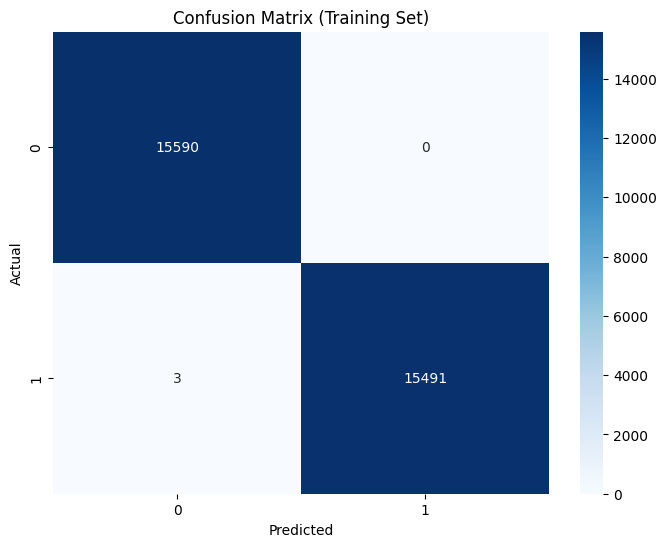

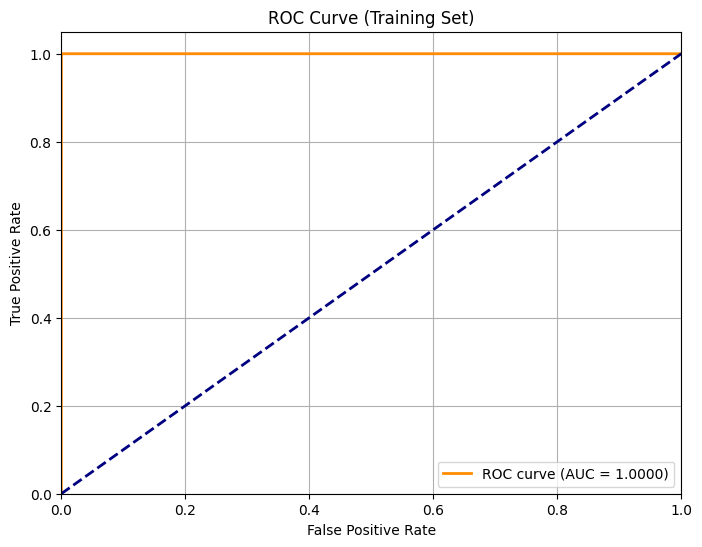


=== Detailed Confusion Matrix Analysis (Training Set) ===
True Negatives: 15590
False Positives: 0
False Negatives: 3
True Positives: 15491

=== Additional Metrics (Training Set) ===
Specificity (True Negative Rate): 1.0000
Negative Predictive Value: 0.9998
False Positive Rate: 0.0000
False Negative Rate: 0.0002

=== Metrik Evaluasi Model (Test Set) ===
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F1 Score: 0.9997

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3838
           1       1.00      1.00      1.00      3934

    accuracy                           1.00      7772
   macro avg       1.00      1.00      1.00      7772
weighted avg       1.00      1.00      1.00      7772



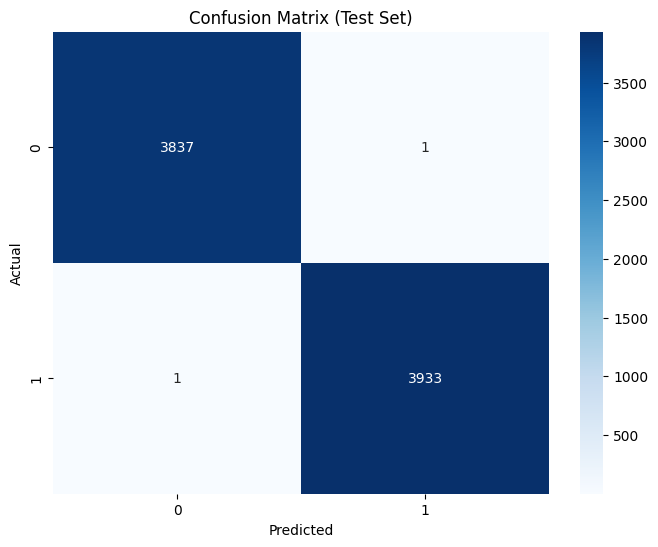

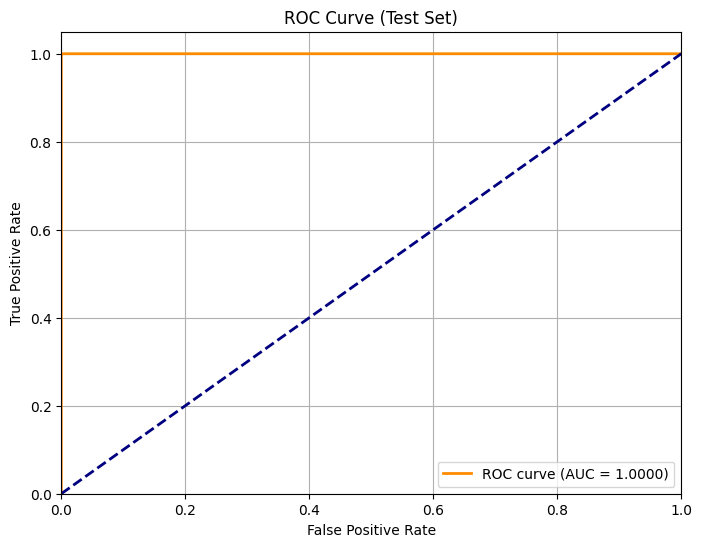


=== Detailed Confusion Matrix Analysis (Test Set) ===
True Negatives: 3837
False Positives: 1
False Negatives: 1
True Positives: 3933

=== Additional Metrics (Test Set) ===
Specificity (True Negative Rate): 0.9997
Negative Predictive Value: 0.9997
False Positive Rate: 0.0003
False Negative Rate: 0.0003

=== Perbandingan Metrik Train vs Test ===
             Training  Testing
accuracy       0.9999   0.9997
precision      1.0000   0.9997
recall         0.9998   0.9997
f1             0.9999   0.9997
auc            1.0000   1.0000
specificity    1.0000   0.9997
npv            0.9998   0.9997
fpr            0.0000   0.0003
fnr            0.0002   0.0003


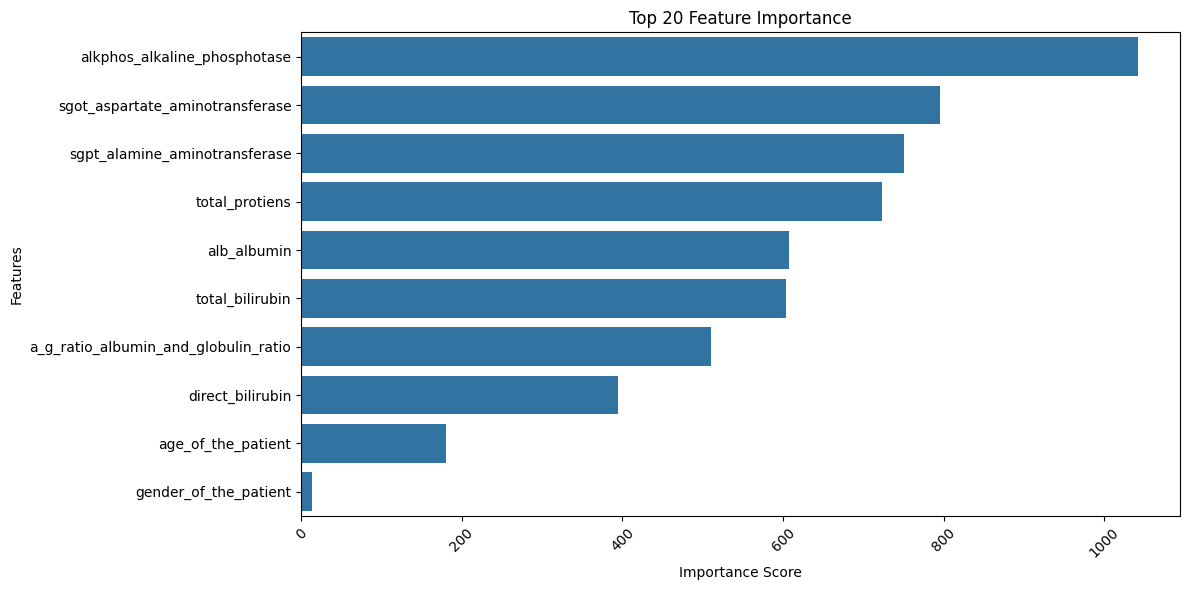

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

def evaluate_and_print_metrics(y_true, y_pred, y_pred_proba, set_name=""):
    """
    Fungsi untuk menghitung dan menampilkan metrik evaluasi
    """
    # Hitung metrik dasar
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n=== Metrik Evaluasi Model ({set_name}) ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Classification Report
    print(f"\n=== Classification Report ({set_name}) ===")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({set_name})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({set_name})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Detail Confusion Matrix
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f"\n=== Detailed Confusion Matrix Analysis ({set_name}) ===")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")

    # Additional Metrics
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    print(f"\n=== Additional Metrics ({set_name}) ===")
    print(f"Specificity (True Negative Rate): {specificity:.4f}")
    print(f"Negative Predictive Value: {npv:.4f}")
    print(f"False Positive Rate: {fpr:.4f}")
    print(f"False Negative Rate: {fnr:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc,
        'specificity': specificity,
        'npv': npv,
        'fpr': fpr,
        'fnr': fnr
    }

# Mendapatkan prediksi untuk data training
y_train_pred_proba = model.predict(dtrain)
y_train_pred = (y_train_pred_proba > 0.5).astype(int)

# Mendapatkan prediksi untuk data testing
y_test_pred_proba = model.predict(dtest)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# Evaluasi untuk training set
train_metrics = evaluate_and_print_metrics(y_train, y_train_pred, y_train_pred_proba, "Training Set")

# Evaluasi untuk test set
test_metrics = evaluate_and_print_metrics(y_test, y_test_pred, y_test_pred_proba, "Test Set")

# Perbandingan metrik train vs test
comparison_df = pd.DataFrame({
    'Training': train_metrics,
    'Testing': test_metrics
}).round(4)

print("\n=== Perbandingan Metrik Train vs Test ===")
print(comparison_df)

# Plot Feature Importance
feature_importance = model.get_fscore()
features = []
importance = []

for feature, score in feature_importance.items():
    features.append(feature)
    importance.append(score)

importance_df = pd.DataFrame({
    'feature': features,
    'importance': importance
})

importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

batas

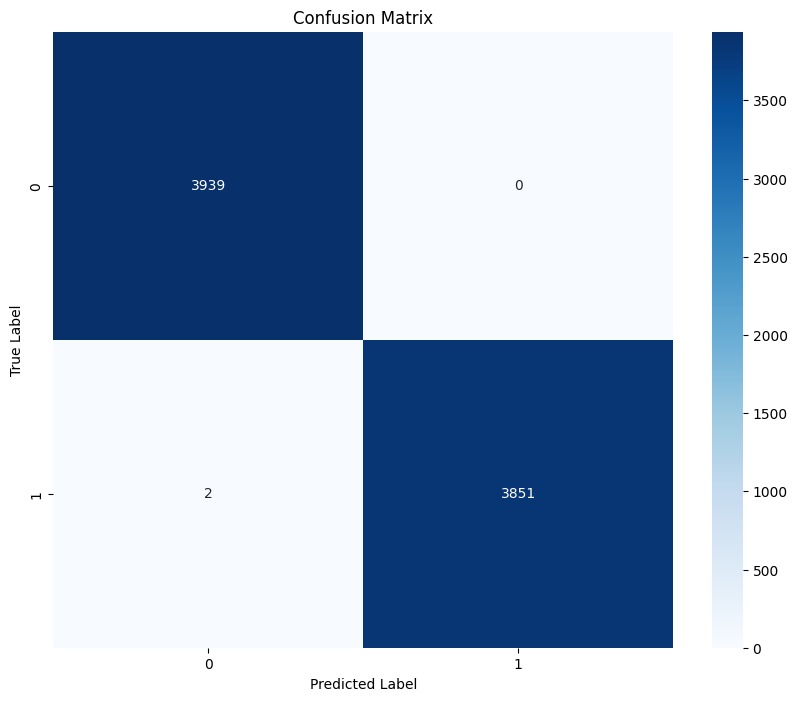


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3939
           1       1.00      1.00      1.00      3853

    accuracy                           1.00      7792
   macro avg       1.00      1.00      1.00      7792
weighted avg       1.00      1.00      1.00      7792


Detailed Metrics:
Accuracy: 0.9997
Precision: 1.0000
Recall: 0.9995
F1-Score: 0.9997


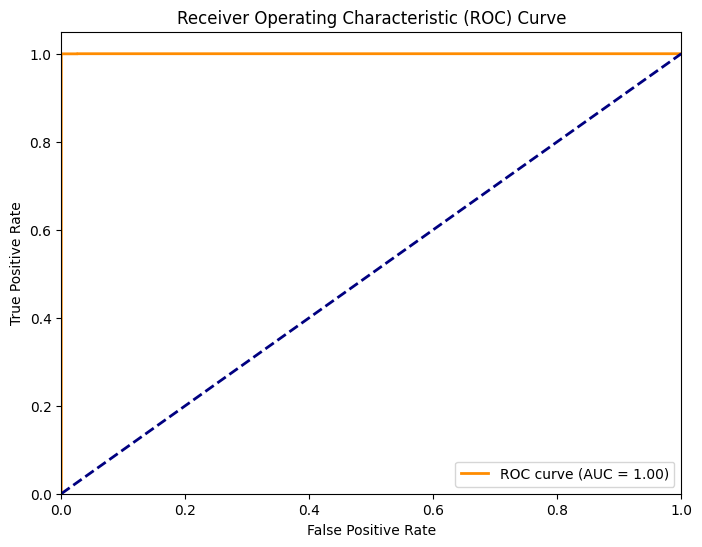

In [ ]:
# import numpy as np
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Get predictions
# y_pred = best_model.predict(X_test)
# y_pred_proba = best_model.predict_proba(X_test)

# # Calculate confusion matrix
# cm = confusion_matrix(y_test, y_pred)

# # Create confusion matrix visualization
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()

# # Print classification report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # Calculate metrics manually
# TP = cm[1,1]
# TN = cm[0,0]
# FP = cm[0,1]
# FN = cm[1,0]

# # Calculate metrics
# accuracy = (TP + TN) / (TP + TN + FP + FN)
# precision = TP / (TP + FP)
# recall = TP / (TP + FN)
# f1_score = 2 * (precision * recall) / (precision + recall)

# print("\nDetailed Metrics:")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1_score:.4f}")

# # Plot ROC Curve
# from sklearn.metrics import roc_curve, auc
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:

# Menghitung presisi (precision), recall, dan F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


# Menampilkan metrik-metrik evaluasi
print(f'Akurasi: {val_accuracy:.4f}')
print(f'Presisi (Precision): {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Validation AUC: {val_auc:.4f}')

TypeError: 'numpy.float64' object is not callable

#####


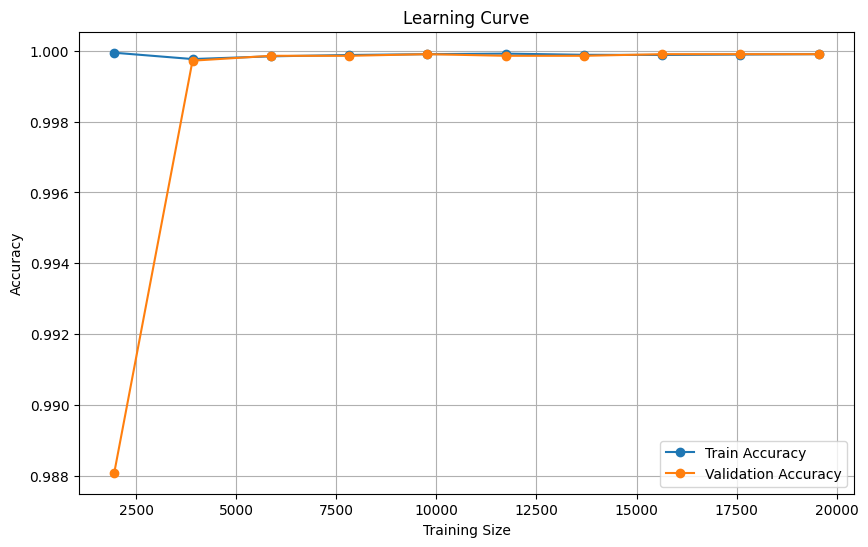

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

# Menampilkan learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Accuracy', marker='o')
plt.plot(train_sizes, validation_scores.mean(axis=1), label='Validation Accuracy', marker='o')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


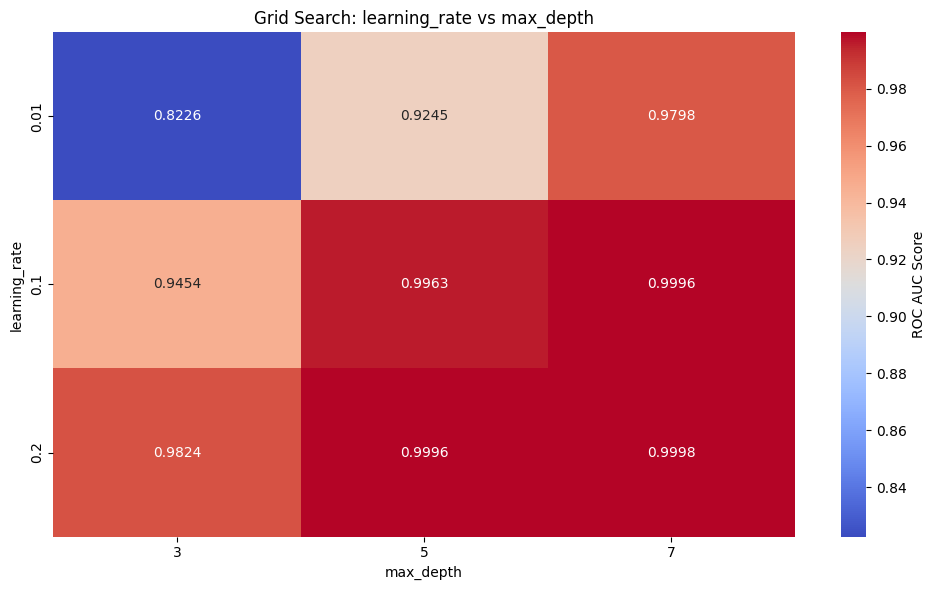

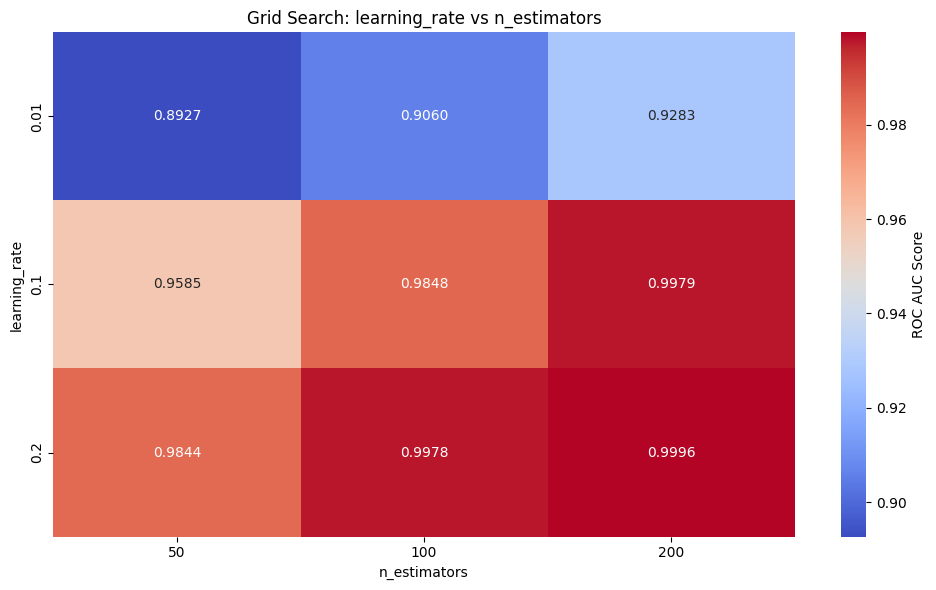

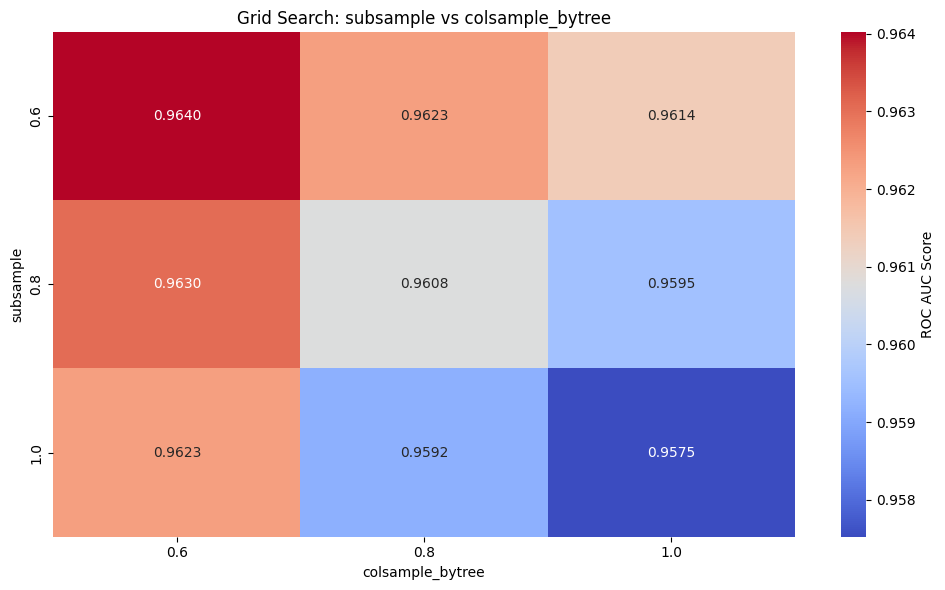

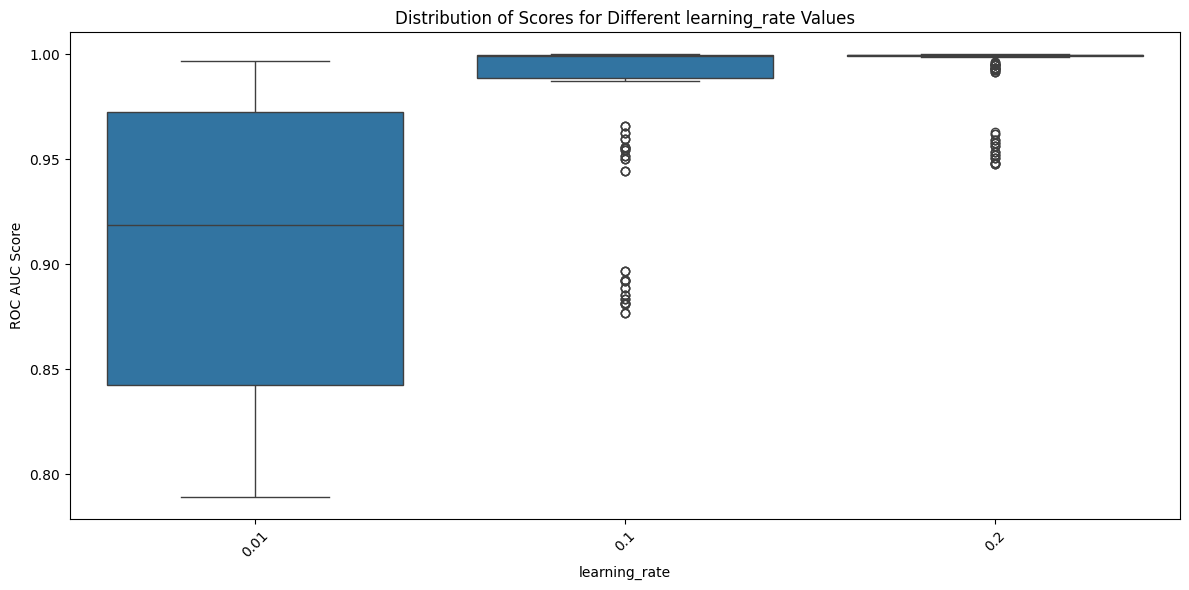

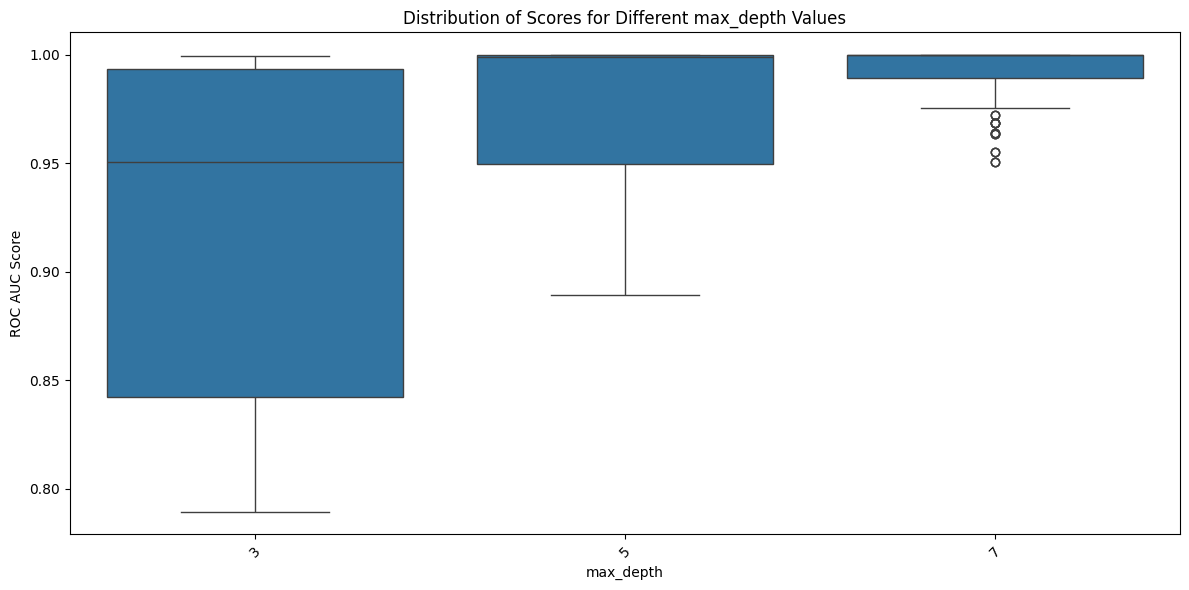

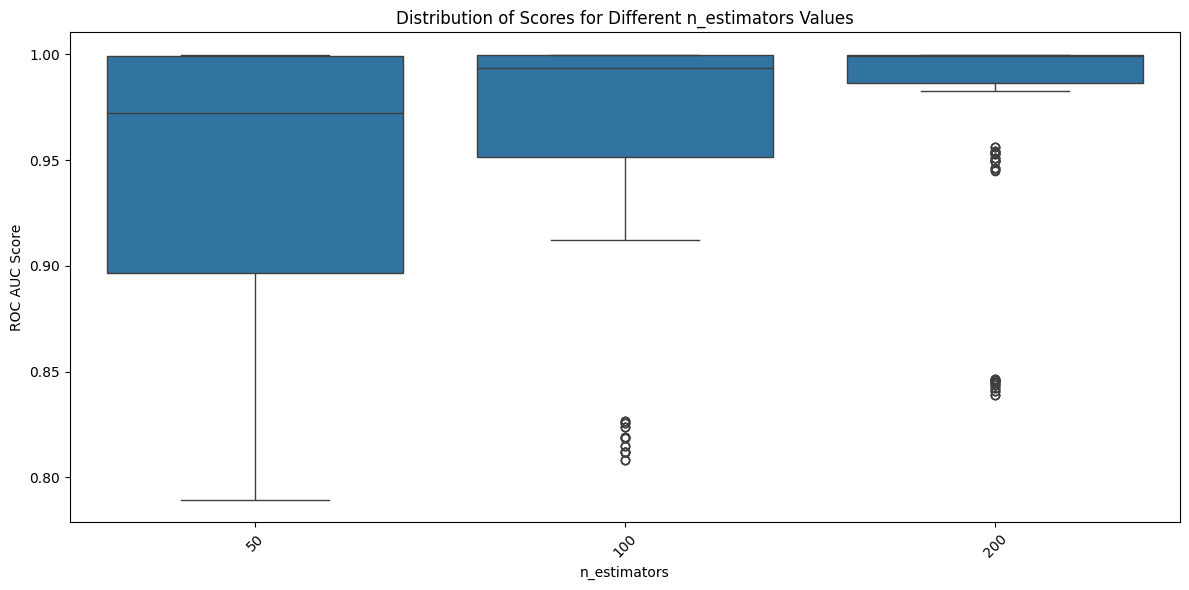

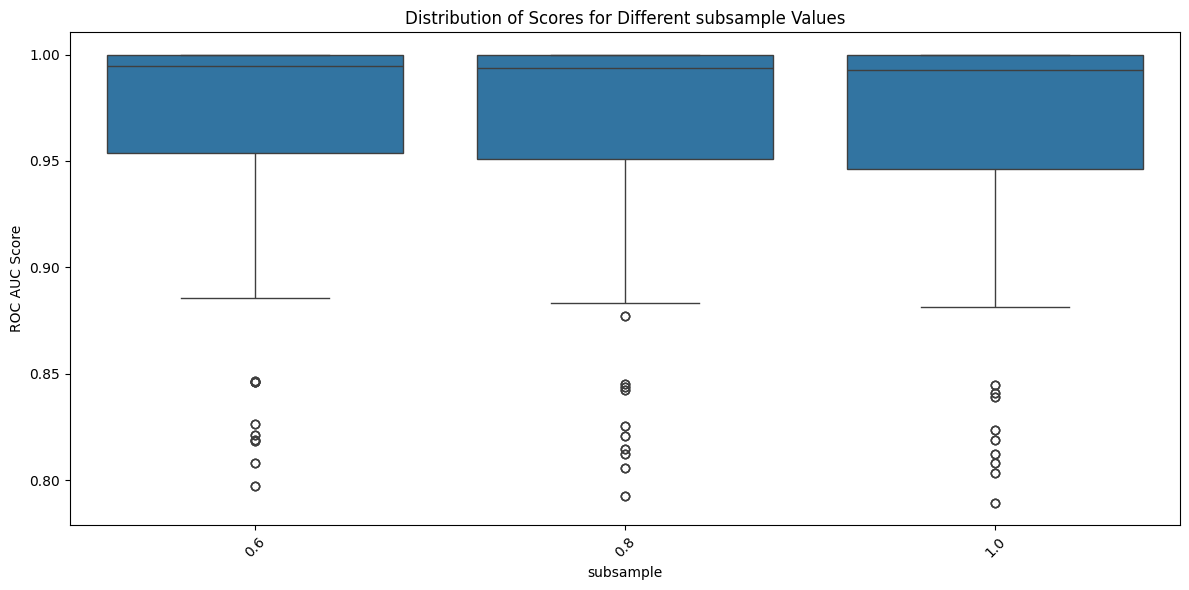

=== Parameter Performance Summary ===

Best Score: 0.9999

Best Parameters:
colsample_bytree: 1.0
gamma: 0.001
learning_rate: 0.2
max_depth: 7
n_estimators: 200
subsample: 0.6

Top 5 Parameter Combinations:

Score: 0.9999
colsample_bytree: 1.0
gamma: 0.001
learning_rate: 0.2
max_depth: 7
n_estimators: 200
subsample: 0.6

Score: 0.9999
colsample_bytree: 1.0
gamma: 0.0001
learning_rate: 0.2
max_depth: 7
n_estimators: 200
subsample: 0.6

Score: 0.9999
colsample_bytree: 1.0
gamma: 0.01
learning_rate: 0.2
max_depth: 7
n_estimators: 200
subsample: 0.8

Score: 0.9999
colsample_bytree: 1.0
gamma: 0.001
learning_rate: 0.2
max_depth: 7
n_estimators: 100
subsample: 0.6

Score: 0.9999
colsample_bytree: 1.0
gamma: 0.0001
learning_rate: 0.2
max_depth: 7
n_estimators: 100
subsample: 0.6


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Mengkonversi hasil GridSearchCV ke DataFrame
def create_cv_results_df(grid_search):
    results = pd.DataFrame(grid_search.cv_results_)
    return results

# Fungsi untuk membuat heatmap perbandingan parameter
def plot_parameter_comparison(grid_search, param1, param2, figsize=(10, 6)):
    # Mendapatkan hasil CV dalam DataFrame
    results_df = create_cv_results_df(grid_search)

    # Mengekstrak nilai parameter
    param1_name = f'param_{param1}'
    param2_name = f'param_{param2}'

    # Membuat pivot table
    pivot_results = results_df.pivot_table(
        index=param1_name,
        columns=param2_name,
        values='mean_test_score'
    )

    # Membuat plot
    plt.figure(figsize=figsize)
    sns.heatmap(pivot_results,
                annot=True,
                cmap='coolwarm',
                fmt='.4f',
                cbar_kws={'label': 'ROC AUC Score'})

    plt.title(f'Grid Search: {param1} vs {param2}')
    plt.xlabel(param2)
    plt.ylabel(param1)
    plt.tight_layout()
    plt.show()

# Membuat visualisasi untuk beberapa kombinasi parameter
# 1. Learning Rate vs Max Depth
plot_parameter_comparison(grid_search, 'learning_rate', 'max_depth')

# 2. Learning Rate vs N Estimators
plot_parameter_comparison(grid_search, 'learning_rate', 'n_estimators')

# 3. Subsample vs Colsample Bytree
plot_parameter_comparison(grid_search, 'subsample', 'colsample_bytree')

# Fungsi untuk membuat plot distribusi skor untuk setiap nilai parameter
def plot_parameter_scores(grid_search, param, figsize=(12, 6)):
    results_df = create_cv_results_df(grid_search)
    param_name = f'param_{param}'

    plt.figure(figsize=figsize)

    # Box plot untuk distribusi skor
    sns.boxplot(x=param_name, y='mean_test_score', data=results_df)

    plt.title(f'Distribution of Scores for Different {param} Values')
    plt.xlabel(param)
    plt.ylabel('ROC AUC Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualisasi distribusi skor untuk beberapa parameter
parameters_to_plot = ['learning_rate', 'max_depth', 'n_estimators', 'subsample']
for param in parameters_to_plot:
    plot_parameter_scores(grid_search, param)

# Membuat rangkuman hasil parameter terbaik
def print_parameter_summary(grid_search):
    results_df = create_cv_results_df(grid_search)
    best_idx = grid_search.best_index_

    print("=== Parameter Performance Summary ===")
    print(f"\nBest Score: {grid_search.best_score_:.4f}")
    print("\nBest Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"{param}: {value}")

    print("\nTop 5 Parameter Combinations:")
    top_5 = results_df.nlargest(5, 'mean_test_score')
    for idx, row in top_5.iterrows():
        print(f"\nScore: {row['mean_test_score']:.4f}")
        params = {param.replace('param_', ''): row[param]
                 for param in results_df.columns
                 if param.startswith('param_')}
        for param, value in params.items():
            print(f"{param}: {value}")

# Menampilkan rangkuman
print_parameter_summary(grid_search)

ROC nya masi perlu di perbaiki

In [ ]:
# === Script untuk export model dan feature names ===
import xgboost as xgb
import json
import numpy as np

# Simpan model ke format JSON
best_model.save_model('xgboost_model.json')

# Definisikan feature names sesuai dengan urutan di dataset
feature_names = {
    'feature_names': [
        'age_of_the_patient',
        'gender_of_the_patient',
        'total_bilirubin',
        'direct_bilirubin',
        'alkphos_alkaline_phosphotase',
        'sgpt_alamine_aminotransferase',
        'sgot_aspartate_aminotransferase',
        'total_protiens',
        'alb_albumin',
        'a_g_ratio_albumin_and_globulin_ratio'
    ]
}

# Simpan feature names ke JSON
with open('feature_names.json', 'w') as f:
    json.dump(feature_names, f, indent=4)

# Untuk memverifikasi bahwa file sudah tersimpan dengan benar
with open('feature_names.json', 'r') as f:
    loaded_features = json.load(f)
print("Features saved successfully:", loaded_features['feature_names'])

Features saved successfully: ['age_of_the_patient', 'gender_of_the_patient', 'total_bilirubin', 'direct_bilirubin', 'alkphos_alkaline_phosphotase', 'sgpt_alamine_aminotransferase', 'sgot_aspartate_aminotransferase', 'total_protiens', 'alb_albumin', 'a_g_ratio_albumin_and_globulin_ratio']
